In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import pickle
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

#Cargar datos y exploración

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/td_ztf_stamp_17_06_20.pkl', 'rb') as file:
    data = pickle.load(file)

print(type(data))
print(data.keys())

<class 'dict'>
dict_keys(['Train', 'Validation', 'Test'])


In [ ]:
train_data = data["Train"]

# Si train_data es un DataFrame:
if isinstance(train_data, pd.DataFrame):
    print(train_data.head())
    print(train_data.info())
else:
    print(type(train_data))

<class 'dict'>


In [ ]:
print(train_data.keys())

dict_keys(['images', 'labels', 'features'])


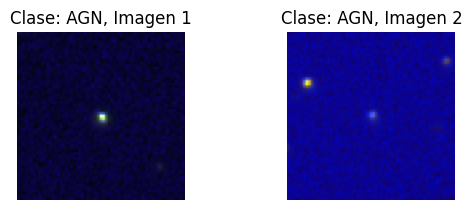

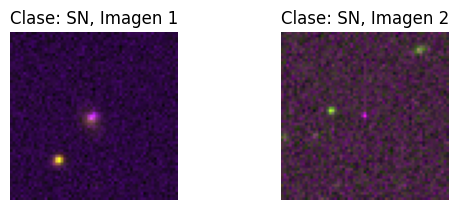

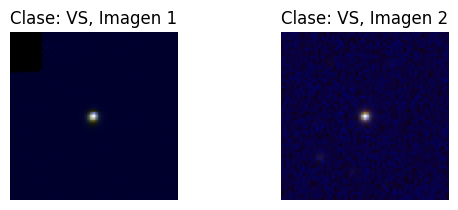

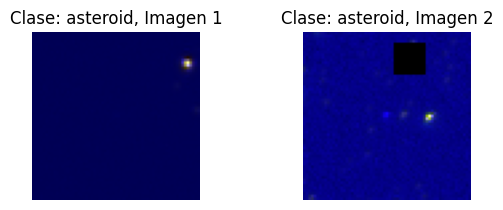

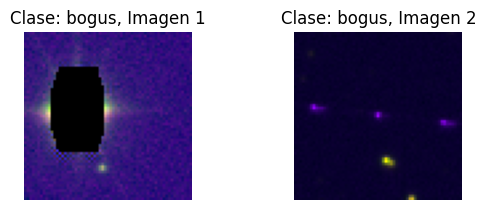

In [ ]:
# Definir nombres de clases
class_names = ['AGN', 'SN', 'VS', 'asteroid', 'bogus']

# Obtener clases únicas
unique_labels = np.unique(train_data["labels"])

# Seleccionar y mostrar dos imágenes de cada clase
for label in unique_labels:
    # Obtener índices de imágenes correspondientes a la clase actual
    indices = np.where(train_data["labels"] == label)[0][:2]  # Tomar los primeros dos índices

    # Mostrar las imágenes
    for i, index in enumerate(indices):
        plt.subplot(2, 2, i + 1)
        plt.imshow(train_data["images"][index], cmap='gray')
        plt.title(f'Clase: {class_names[label]}, Imagen {i + 1}')
        plt.axis('off')

    plt.show()

#Pre procesamiento de datos

In [ ]:
# Cargar los datos
train_data = data["Train"]
val_data = data["Validation"]
test_data = data["Test"]

# Convertir los datos de entrenamiento a un tensor de PyTorch.
train_images = torch.from_numpy(train_data["images"])
train_labels = torch.from_numpy(train_data["labels"])

# Convertir los datos de validación a un tensor de PyTorch.
val_images = torch.from_numpy(val_data["images"])
val_labels = torch.from_numpy(val_data["labels"])

# Convertir los datos de prueba a un tensor de PyTorch.
test_images = torch.from_numpy(test_data["images"])
test_labels = torch.from_numpy(test_data["labels"])

In [ ]:
# Cambiar la forma de los datos de entrada
train_images = train_images.permute(0, 3, 1, 2)
val_images = val_images.permute(0, 3, 1, 2)
test_images = test_images.permute(0, 3, 1, 2)

In [ ]:
# Aplicar recorte al centro
def center_crop_images(images):
    cropped_images = TF.center_crop(images, (21, 21))
    return cropped_images

In [ ]:
# Aplicar el preprocesamiento a los conjuntos de entrenamiento, validación y prueba
train_images = center_crop_images(train_images)
val_images = center_crop_images(val_images)
test_images = center_crop_images(test_images)

# Crear dataloader de entrenamiento
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Crear dataloader de validación
val_dataset = TensorDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Crear dataloader de prueba
test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Modelo Crop, sin Zero Padding

# Arquitectura Base, sin Zero Padding

| Capa | Tipo de Capa                | Entradas | Salidas | Kernel/Pool | Stride | Padding |
|------|-----------------------------|----------|---------|-------------|--------|---------|
| 1    | Rotaciones                  | 3        | 3       | 3x3         | 1      | 1       |
| 2    | Conv1                       | 3        | 32      | 4x4         | 1      | 2       |
| 3    | Conv2                       | 32       | 32      | 3x3         | 1      | 1       |
| 4    | MaxPool1                     | -       | -       | 2x2         | 2      | -       |
| 5    | Conv3                       | 32       | 64      | 3x3         | 1      | 1       |
| 6    | Conv4                       | 64       | 64      | 3x3         | 1      | 1       |
| 7    | Conv5                       | 64       | 64      | 3x3         | 1      | 1       |
| 8    | MaxPool2                     | -       | -       | 2x2         | 2      | -       |
| 9    | Cyclic Pooling              | 64       | 128     | -           | -      | -       |
| 10   | Flatten                     | -       | -       | -           | -      | -       |
| 11   | Dense1                      | 512      | 64      | -           | -      | -       |
| 12   | Dense2                      | 64       | 64      | -           | -      | -       |
| 13   | Salida                      | 64       | 5       | -           | -      | -       |
| 14   | Dropout                     | -       | -       | -           | -      | -       |


In [ ]:
#Rotaciones
def RotAugmentation(x_0):
    #print(x_0[1,1,:,:].shape)
    x_1 = x_0
    x_2 = x_0
    x_3 = x_0

    for i in range (x_0.shape[0]):
      for j in range (3):
        x_1[i,j,:,:] = torch.rot90(x_0[i,j,:,:], 1, [0,1])
        x_2[i,j,:,:] = torch.rot90(x_0[i,j,:,:], 2, [0,1])
        x_3[i,j,:,:] = torch.rot90(x_0[i,j,:,:], 3, [0,1])

    return [x_0,x_1,x_2,x_3]

In [ ]:
class CyclicPool(nn.Module):
    def __init__(self, in_channels):
        super(CyclicPool, self).__init__()
        self.in_channels = in_channels
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x_avg = self.avg_pool(x)
        x_max = self.max_pool(x)
        x = torch.cat([x_avg, x_max], dim=1)
        return x


class SupernovaDetector(nn.Module):
    def __init__(self):
        super(SupernovaDetector, self).__init__()
        # Rotaciones
        self.rotation = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Capas Convolucionales
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        # Max-pooling
        self.pool1 = nn.MaxPool2d(2, 2)
        # Capas Convolucionales
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        # Max-pooling
        self.pool2 = nn.MaxPool2d(2, 2)
        # Cyclic pooling
        self.cyclic_pool = CyclicPool(64)
        # Flatten
        self.flatten = nn.Flatten()
        # Dense layer (FC)
        self.dense1 = nn.Linear(512, 64)
        self.dense2 = nn.Linear(64, 64)
        # Output dropout softmax
        self.output_layer = nn.Linear(64, 5)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
       # Aplicar rotaciones al inicio
        x_rotated_list = RotAugmentation(x)
        # Concatenar a lo largo de la dimensión del lote (batch dimension)
        x_rotated = torch.cat(x_rotated_list, dim=0)
        x = self.conv1(x)  # Capas Convolucionales
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x) # Max-pooling
        x = self.conv3(x) # Capas Convolucionales
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool2(x) # Max-pooling
        x = self.cyclic_pool(x) # Cyclic pooling
        x = self.flatten(x) # Flatten
        x = self.dense1(x)  # Dense layer (FC)
        x = F.relu(x)
        x = self.dropout(x) # Dropout
        x = self.dense2(x)  # Dense layer (FC)
        x = F.relu(x)
        x = self.dropout(x) #Dropout
        x = self.output_layer(x) #Output softmax
        return x

#Entrenamiento

In [ ]:
# Número de épocas y tamaño de lote
num_epochs = 10
batch_size = 32

# Definir el modelo, optimizador y función de pérdida
model = SupernovaDetector()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Entrenar el modelo
for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # Poner a cero los gradientes
        optimizer.zero_grad()

        # Propagación hacia adelante
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calcular estadísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Imprimir estadísticas
        if i % 100 == 99:  # Imprimir cada 100 lotes
            print(f'Época [{epoch + 1}, Lote {i + 1}], Pérdida: {running_loss / 100:.3f}, Precisión: {100 * correct / total:.2f}%')
            running_loss = 0.0

    end_time = time.time()
    print(f'Tiempo de época: {end_time - start_time:.2f} segundos')

print('Entrenamiento finalizado')

Época [1, Lote 100], Pérdida: 1.545, Precisión: 27.41%
Época [1, Lote 200], Pérdida: 1.288, Precisión: 34.81%
Época [1, Lote 300], Pérdida: 1.136, Precisión: 40.47%
Época [1, Lote 400], Pérdida: 1.023, Precisión: 44.62%
Época [1, Lote 500], Pérdida: 1.014, Precisión: 47.33%
Época [1, Lote 600], Pérdida: 0.941, Precisión: 49.70%
Época [1, Lote 700], Pérdida: 0.908, Precisión: 51.58%
Época [1, Lote 800], Pérdida: 0.924, Precisión: 52.98%
Época [1, Lote 900], Pérdida: 0.879, Precisión: 54.34%
Época [1, Lote 1000], Pérdida: 0.858, Precisión: 55.47%
Época [1, Lote 1100], Pérdida: 0.833, Precisión: 56.68%
Época [1, Lote 1200], Pérdida: 0.850, Precisión: 57.61%
Época [1, Lote 1300], Pérdida: 0.819, Precisión: 58.42%
Época [1, Lote 1400], Pérdida: 0.815, Precisión: 59.12%
Época [1, Lote 1500], Pérdida: 0.777, Precisión: 59.90%
Época [1, Lote 1600], Pérdida: 0.779, Precisión: 60.58%
Época [1, Lote 1700], Pérdida: 0.791, Precisión: 61.32%
Época [1, Lote 1800], Pérdida: 0.773, Precisión: 61.89%
É

In [ ]:
# Guardar el modelo
torch.save(model.state_dict(), 'supernova_detectorcropnozpadd.pth')

# Para descargar el modelo
from google.colab import files
files.download('supernova_detectorcropnozpadd.pth')
# 35min aprox.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Evaluación del Modelo

In [ ]:
# Definir una función para evaluar el modelo
def evaluate_model(model, data_loader):
    model.eval()  # Establecer el modelo en modo de evaluación
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluar en el conjunto de prueba
test_accuracy = evaluate_model(model, test_loader)
print(f'Precisión en el conjunto de prueba: {test_accuracy:.2f}%')

Precisión en el conjunto de prueba: 82.80%


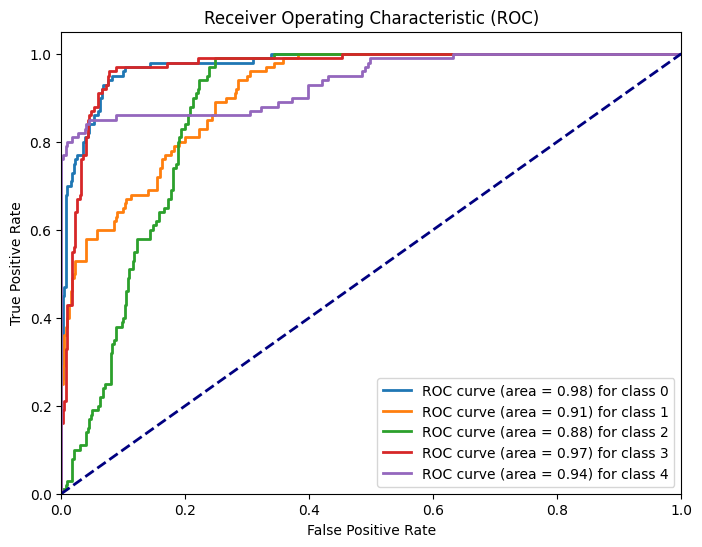

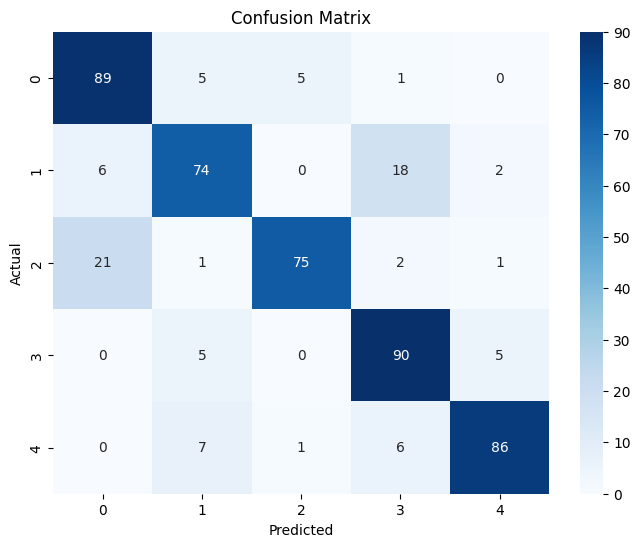

In [ ]:
def evaluate_model_roc_confusion(model, data_loader):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            all_labels.extend(labels.numpy())
            all_scores.extend(outputs.numpy())

    n_classes = len(np.unique(all_labels))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        true_labels = np.array(all_labels) == i
        scores = [score[i] for score in all_scores]
        fpr[i], tpr[i], _ = roc_curve(true_labels, scores)
        roc_auc[i] = roc_auc_score(true_labels, scores)

    # Confusion matrix
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_scores).argmax(axis=1)
    cm = confusion_matrix(all_labels, all_predictions)

    return fpr, tpr, roc_auc, cm

fpr, tpr, roc_auc, cm = evaluate_model_roc_confusion(model, test_loader)

# Plot ROC curves para cada clase
plt.figure(figsize=(8, 6))
n_classes = len(roc_auc)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

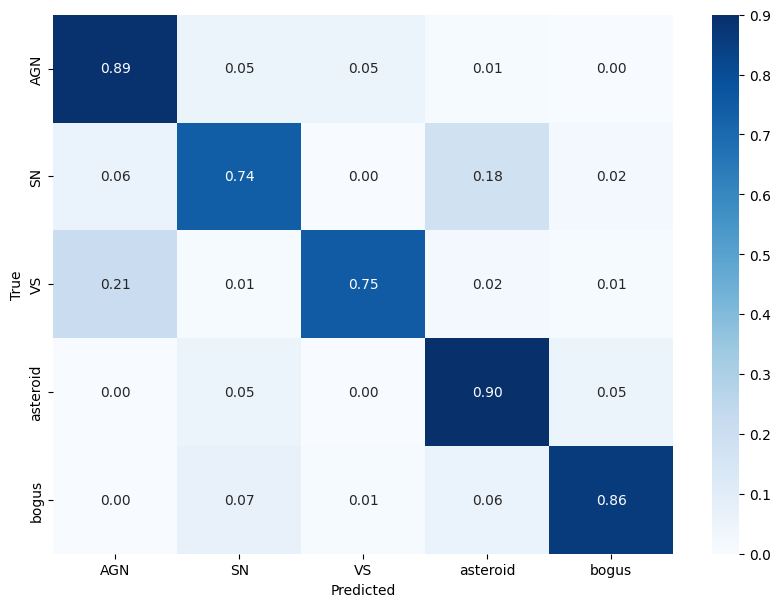

In [ ]:
# Normalizar la matriz de confusión
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = ['AGN', 'SN', 'VS', 'asteroid', 'bogus']

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
def evaluate_model_metrics(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    # Convertir las listas a arrays numpy
    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)

    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision por clase: {precision_per_class}")
    print(f"Recall por clase: {recall_per_class}")
    print(f"F1 Score por clase: {f1_per_class}")
    print(f"Matriz de Confusión:\n{conf_matrix}")

    # Retornar las métricas
    return accuracy, precision_per_class, recall_per_class, f1_per_class, conf_matrix

# Llamar a la función para obtener las métricas
accuracy, precision, recall, f1, conf_matrix = evaluate_model_metrics(model, test_loader)

Accuracy: 0.828
Precision por clase: [0.76724138 0.80434783 0.92592593 0.76923077 0.91489362]
Recall por clase: [0.89 0.74 0.75 0.9  0.86]
F1 Score por clase: [0.82407407 0.77083333 0.82872928 0.82949309 0.88659794]
Matriz de Confusión:
[[89  5  5  1  0]
 [ 6 74  0 18  2]
 [21  1 75  2  1]
 [ 0  5  0 90  5]
 [ 0  7  1  6 86]]


# Modelo Crop, con Zero Padding

# Arquitectura Base con Zero Padding

| Capa | Tipo de Capa        | Entradas | Salidas | Kernel/Pool | Stride | Padding |
|------|---------------------|----------|---------|-------------|--------|---------|
| 1    | Zero Padding        | -        | -       | -           | -      | 3       |
| 2    | Rotaciones          | 3        | 3       | 3x3         | 1      | 1       |
| 3    | Conv1               | 3        | 32      | 4x4         | 1      | 2       |
| 4    | Conv2               | 32       | 32      | 3x3         | 1      | 1       |
| 5    | MaxPool1            | -        | -       | 2x2         | 2      | -       |
| 6    | Conv3               | 32       | 64      | 3x3         | 1      | 1       |
| 7    | Conv4               | 64       | 64      | 3x3         | 1      | 1       |
| 8    | Conv5               | 64       | 64      | 3x3         | 1      | 1       |
| 9    | MaxPool2            | -        | -       | 2x2         | 2      | -       |
| 10   | Cyclic Pooling      | 64       | 128     | -           | -      | -       |
| 11   | Flatten             | -        | -       | -           | -      | -       |
| 12   | Dense1              | 1152     | 64      | -           | -      | -       |
| 13   | Dense2              | 64       | 64      | -           | -      | -       |
| 14   | Salida              | 64       | 5       | -           | -      | -       |
| 15   | Dropout             | -        | -       | -           | -      | -       |


In [ ]:
def RotAugmentation(x_0):
    #print(x_0[1,1,:,:].shape)
    x_1 = x_0
    x_2 = x_0
    x_3 = x_0

    for i in range (x_0.shape[0]):
      for j in range (3):
        x_1[i,j,:,:] = torch.rot90(x_0[i,j,:,:], 1, [0,1])
        x_2[i,j,:,:] = torch.rot90(x_0[i,j,:,:], 2, [0,1])
        x_3[i,j,:,:] = torch.rot90(x_0[i,j,:,:], 3, [0,1])

    return [x_0,x_1,x_2,x_3]

In [ ]:
class CyclicPool(nn.Module):
    def __init__(self, in_channels):
        super(CyclicPool, self).__init__()
        self.in_channels = in_channels
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x_avg = self.avg_pool(x)
        x_max = self.max_pool(x)
        x = torch.cat([x_avg, x_max], dim=1)
        return x

In [ ]:
class SupernovaDetector(nn.Module):
    def __init__(self):
        super(SupernovaDetector, self).__init__()

        # Zero padding layer
        self.zero_padding = nn.ZeroPad2d(3)

        # Rotaciones
        self.rotation = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Capas Convolucionales
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        # Max-pooling
        self.pool1 = nn.MaxPool2d(2, 2)
        # Capas Convolucionales
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        # Max-pooling
        self.pool2 = nn.MaxPool2d(2, 2)
        # Cyclic pooling
        self.cyclic_pool = CyclicPool(64)
        # Flatten
        self.flatten = nn.Flatten()
        # Dense layer (FC)
        self.dense1 = nn.Linear(1152, 64)
        self.dense2 = nn.Linear(64, 64)
        # Output dropout softmax
        self.output_layer = nn.Linear(64, 5)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.zero_padding(x)
       # Aplicar rotaciones al inicio
        x_rotated_list = RotAugmentation(x)
        # Concatenar a lo largo de la dimensión del lote (batch dimension)
        x_rotated = torch.cat(x_rotated_list, dim=0)
        x = self.conv1(x)  # Capas Convolucionales
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x) # Max-pooling
        x = self.conv3(x) # Capas Convolucionales
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool2(x) # Max-pooling
        x = self.cyclic_pool(x) # Cyclic pooling
        x = self.flatten(x) # Flatten
        x = self.dense1(x)  # Dense layer (FC)
        x = F.relu(x)
        x = self.dropout(x) # Dropout
        x = self.dense2(x)  # Dense layer (FC)
        x = F.relu(x)
        x = self.dropout(x) #Dropout
        x = self.output_layer(x) #Output softmax
        return x

# Entrenamiento

In [ ]:
# Número de épocas y tamaño de lote
num_epochs = 10
batch_size = 32

# Definir el modelo, optimizador y función de pérdida
model = SupernovaDetector()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Entrenar el modelo
for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # Poner a cero los gradientes
        optimizer.zero_grad()

        # Propagación hacia adelante
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calcular estadísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Imprimir estadísticas
        if i % 100 == 99:  # Imprimir cada 100 lotes
            print(f'Época [{epoch + 1}, Lote {i + 1}], Pérdida: {running_loss / 100:.3f}, Precisión: {100 * correct / total:.2f}%')
            running_loss = 0.0

    end_time = time.time()
    print(f'Tiempo de época: {end_time - start_time:.2f} segundos')

print('Entrenamiento finalizado')

Época [1, Lote 100], Pérdida: 1.567, Precisión: 26.50%
Época [1, Lote 200], Pérdida: 1.301, Precisión: 34.02%
Época [1, Lote 300], Pérdida: 1.156, Precisión: 37.55%
Época [1, Lote 400], Pérdida: 1.111, Precisión: 39.77%
Época [1, Lote 500], Pérdida: 1.033, Precisión: 42.45%
Época [1, Lote 600], Pérdida: 1.011, Precisión: 44.69%
Época [1, Lote 700], Pérdida: 0.983, Precisión: 46.52%
Época [1, Lote 800], Pérdida: 0.945, Precisión: 48.18%
Época [1, Lote 900], Pérdida: 0.914, Precisión: 49.91%
Época [1, Lote 1000], Pérdida: 0.865, Precisión: 51.55%
Época [1, Lote 1100], Pérdida: 0.866, Precisión: 52.90%
Época [1, Lote 1200], Pérdida: 0.852, Precisión: 54.19%
Época [1, Lote 1300], Pérdida: 0.816, Precisión: 55.36%
Época [1, Lote 1400], Pérdida: 0.801, Precisión: 56.35%
Época [1, Lote 1500], Pérdida: 0.758, Precisión: 57.33%
Época [1, Lote 1600], Pérdida: 0.781, Precisión: 58.21%
Época [1, Lote 1700], Pérdida: 0.754, Precisión: 59.00%
Época [1, Lote 1800], Pérdida: 0.767, Precisión: 59.71%
É

In [ ]:
# Guardar el modelo
torch.save(model.state_dict(), 'supernova_detectorcropzpadd.pth')

# Para descargar el modelo
from google.colab import files
files.download('supernova_detectorcropzpadd.pth')
# 35min aprox.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluación del Modelo

In [ ]:
# Definir una función para evaluar el modelo
def evaluate_model(model, data_loader):
    model.eval()  # Establecer el modelo en modo de evaluación
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluar en el conjunto de prueba
test_accuracy = evaluate_model(model, test_loader)
print(f'Precisión en el conjunto de prueba: {test_accuracy:.2f}%')

Precisión en el conjunto de prueba: 84.40%


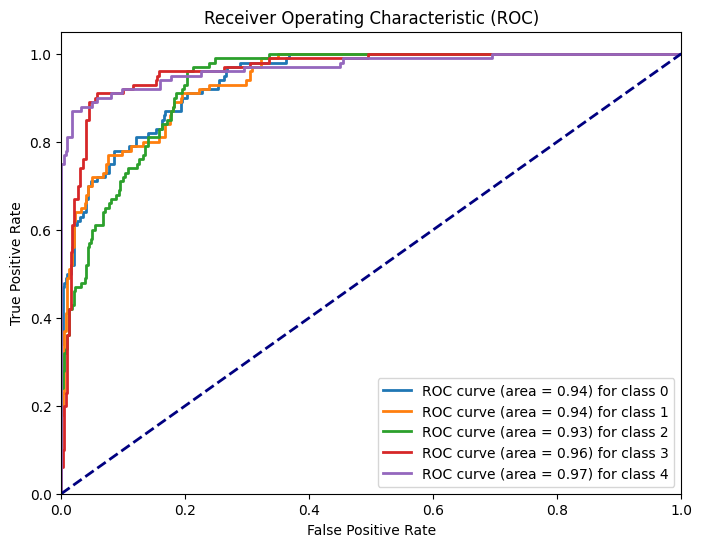

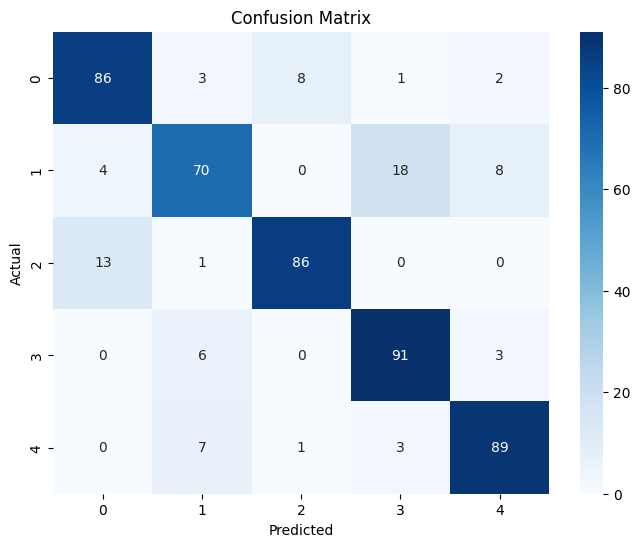

In [ ]:
def evaluate_model_roc_confusion(model, data_loader):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            all_labels.extend(labels.numpy())
            all_scores.extend(outputs.numpy())

    n_classes = len(np.unique(all_labels))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        true_labels = np.array(all_labels) == i
        scores = [score[i] for score in all_scores]
        fpr[i], tpr[i], _ = roc_curve(true_labels, scores)
        roc_auc[i] = roc_auc_score(true_labels, scores)

    # Confusion matrix
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_scores).argmax(axis=1)
    cm = confusion_matrix(all_labels, all_predictions)

    return fpr, tpr, roc_auc, cm

fpr, tpr, roc_auc, cm = evaluate_model_roc_confusion(model, test_loader)

# Plot ROC curves para cada clase
plt.figure(figsize=(8, 6))
n_classes = len(roc_auc)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

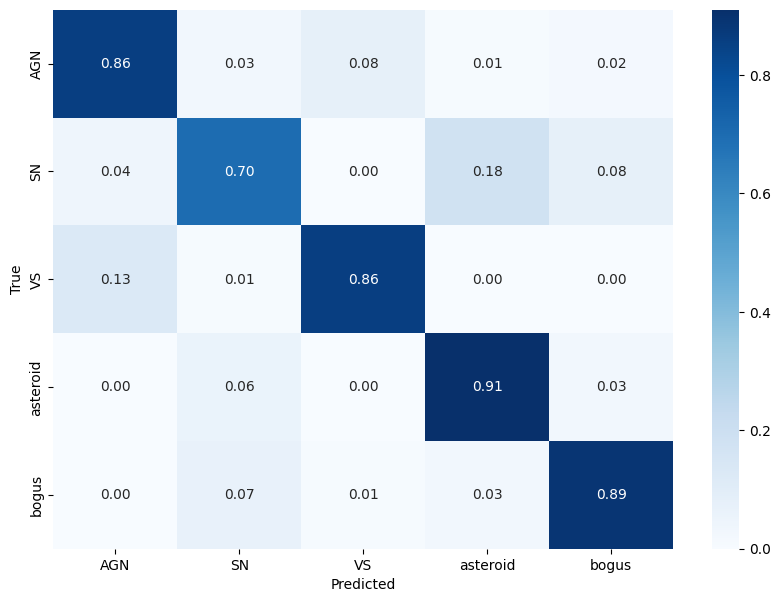

In [ ]:
# Normalizar la matriz de confusión
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = ['AGN', 'SN', 'VS', 'asteroid', 'bogus']

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
def evaluate_model_metrics(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    # Convertir las listas a arrays numpy
    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)

    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision por clase: {precision_per_class}")
    print(f"Recall por clase: {recall_per_class}")
    print(f"F1 Score por clase: {f1_per_class}")
    print(f"Matriz de Confusión:\n{conf_matrix}")

    # Retornar las métricas
    return accuracy, precision_per_class, recall_per_class, f1_per_class, conf_matrix

# Llamar a la función para obtener las métricas
accuracy, precision, recall, f1, conf_matrix = evaluate_model_metrics(model, test_loader)

Accuracy: 0.844
Precision por clase: [0.83495146 0.8045977  0.90526316 0.80530973 0.87254902]
Recall por clase: [0.86 0.7  0.86 0.91 0.89]
F1 Score por clase: [0.84729064 0.7486631  0.88205128 0.85446009 0.88118812]
Matriz de Confusión:
[[86  3  8  1  2]
 [ 4 70  0 18  8]
 [13  1 86  0  0]
 [ 0  6  0 91  3]
 [ 0  7  1  3 89]]


# Arquitectura Crop, Sin Zero Padding, Zoom

# Arquitectura Base, Rotaciones, Zoom, Sin Zero Padding

| Capa | Tipo de Capa        | Entradas | Salidas | Kernel/Pool | Stride | Padding |
|------|---------------------|----------|---------|-------------|--------|---------|
| 1    | Aumentación         | 3        | 3       | 3x3         | 1      | 1       |
| 2    | Conv1               | 3        | 32      | 4x4         | 1      | 2       |
| 3    | Conv2               | 32       | 32      | 3x3         | 1      | 1       |
| 4    | MaxPool1            | -        | -       | 2x2         | 2      | -       |
| 5    | Conv3               | 32       | 64      | 3x3         | 1      | 1       |
| 6    | Conv4               | 64       | 64      | 3x3         | 1      | 1       |
| 7    | Conv5               | 64       | 64      | 3x3         | 1      | 1       |
| 8    | MaxPool2            | -        | -       | 2x2         | 2      | -       |
| 9    | Cyclic Pooling      | 64       | 128     | -           | -      | -       |
| 10   | Flatten             | -        | -       | -           | -      | -       |
| 11   | Dense1              | 512      | 64      | -           | -      | -       |
| 12   | Dense2              | 64       | 64      | -           | -      | -       |
| 13   | Salida              | 64       | 5       | -           | -      | -       |
| 14   | Dropout             | -        | -       | -           | -      | -       |


In [ ]:
def Augmentation(x_0, zoom_factor=1.2):
    x_1 = x_0.clone()
    x_2 = x_0.clone()
    x_3 = x_0.clone()

    for i in range(x_0.shape[0]):
        for j in range(3):
            # Rotaciones
            x_1[i, j, :, :] = torch.rot90(x_0[i, j, :, :], 1, [0, 1])
            x_2[i, j, :, :] = torch.rot90(x_0[i, j, :, :], 2, [0, 1])
            x_3[i, j, :, :] = torch.rot90(x_0[i, j, :, :], 3, [0, 1])

            # Zoom
            zoomed_image = TF.affine(x_0[i, j, :, :].unsqueeze(0), angle=0, translate=(0, 0), scale=zoom_factor, shear=0)
            x_1[i, j, :, :] = zoomed_image.squeeze(0)

    return [x_0, x_1, x_2, x_3]

In [ ]:
class CyclicPool(nn.Module):
    def __init__(self, in_channels):
        super(CyclicPool, self).__init__()
        self.in_channels = in_channels
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x_avg = self.avg_pool(x)
        x_max = self.max_pool(x)
        x = torch.cat([x_avg, x_max], dim=1)
        return x

In [ ]:
class SupernovaDetector(nn.Module):
    def __init__(self, zoom_factor=1.2):
        super(SupernovaDetector, self).__init__()
        self.zoom_factor = zoom_factor

        # Aumentación de datos (rotaciones y zoom)
        self.augmentation = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Capas Convolucionales
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        # Max-pooling
        self.pool1 = nn.MaxPool2d(2, 2)
        # Capas Convolucionales
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        # Max-pooling
        self.pool2 = nn.MaxPool2d(2, 2)
        # Cyclic pooling
        self.cyclic_pool = CyclicPool(64)
        # Flatten
        self.flatten = nn.Flatten()
        # Dense layer (FC)
        self.dense1 = nn.Linear(512, 64)
        self.dense2 = nn.Linear(64, 64)
        # Output dropout softmax
        self.output_layer = nn.Linear(64, 5)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Aplicar rotaciones y zoom al inicio
        x_augmented_list = Augmentation(x, zoom_factor=self.zoom_factor)
        # Concatenar a lo largo de la dimensión del lote (batch dimension)
        x_augmented = torch.cat(x_augmented_list, dim=0)
        x = self.conv1(x)  # Capas Convolucionales
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x) # Max-pooling
        x = self.conv3(x) # Capas Convolucionales
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool2(x) # Max-pooling
        x = self.cyclic_pool(x) # Cyclic pooling
        x = self.flatten(x) # Flatten
        x = self.dense1(x)  # Dense layer (FC)
        x = F.relu(x)
        x = self.dropout(x) # Dropout
        x = self.dense2(x)  # Dense layer (FC)
        x = F.relu(x)
        x = self.dropout(x) #Dropout
        x = self.output_layer(x) #Output softmax
        return x

# Entrenamiento

In [ ]:
# Número de épocas y tamaño de lote
num_epochs = 10
batch_size = 32

# Definir el modelo, optimizador y función de pérdida
model = SupernovaDetector()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Entrenar el modelo
for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # Poner a cero los gradientes
        optimizer.zero_grad()

        # Propagación hacia adelante
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calcular estadísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Imprimir estadísticas
        if i % 100 == 99:  # Imprimir cada 100 lotes
            print(f'Época [{epoch + 1}, Lote {i + 1}], Pérdida: {running_loss / 100:.3f}, Precisión: {100 * correct / total:.2f}%')
            running_loss = 0.0

    end_time = time.time()
    print(f'Tiempo de época: {end_time - start_time:.2f} segundos')

print('Entrenamiento finalizado')

Época [1, Lote 100], Pérdida: 1.596, Precisión: 22.50%
Época [1, Lote 200], Pérdida: 1.490, Precisión: 26.95%
Época [1, Lote 300], Pérdida: 1.349, Precisión: 30.81%
Época [1, Lote 400], Pérdida: 1.196, Precisión: 33.98%
Época [1, Lote 500], Pérdida: 1.133, Precisión: 36.89%
Época [1, Lote 600], Pérdida: 1.072, Precisión: 39.90%
Época [1, Lote 700], Pérdida: 1.010, Precisión: 42.66%
Época [1, Lote 800], Pérdida: 0.938, Precisión: 45.16%
Época [1, Lote 900], Pérdida: 0.900, Precisión: 47.32%
Época [1, Lote 1000], Pérdida: 0.927, Precisión: 49.05%
Época [1, Lote 1100], Pérdida: 0.873, Precisión: 50.54%
Época [1, Lote 1200], Pérdida: 0.850, Precisión: 51.94%
Época [1, Lote 1300], Pérdida: 0.846, Precisión: 53.14%
Época [1, Lote 1400], Pérdida: 0.856, Precisión: 54.16%
Época [1, Lote 1500], Pérdida: 0.790, Precisión: 55.18%
Época [1, Lote 1600], Pérdida: 0.822, Precisión: 56.04%
Época [1, Lote 1700], Pérdida: 0.827, Precisión: 56.83%
Época [1, Lote 1800], Pérdida: 0.752, Precisión: 57.66%
É

In [ ]:
# Guardar el modelo
torch.save(model.state_dict(), 'supernova_detectorzoombasesinzpadd.pth')

# Para descargar el modelo
from google.colab import files
files.download('supernova_detectorzoombasesinzpadd.pth')
# 35min aprox.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluación del Modelo

In [ ]:
# Definir una función para evaluar el modelo
def evaluate_model(model, data_loader):
    model.eval()  # Establecer el modelo en modo de evaluación
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluar en el conjunto de prueba
test_accuracy = evaluate_model(model, test_loader)
print(f'Precisión en el conjunto de prueba: {test_accuracy:.2f}%')

Precisión en el conjunto de prueba: 84.00%


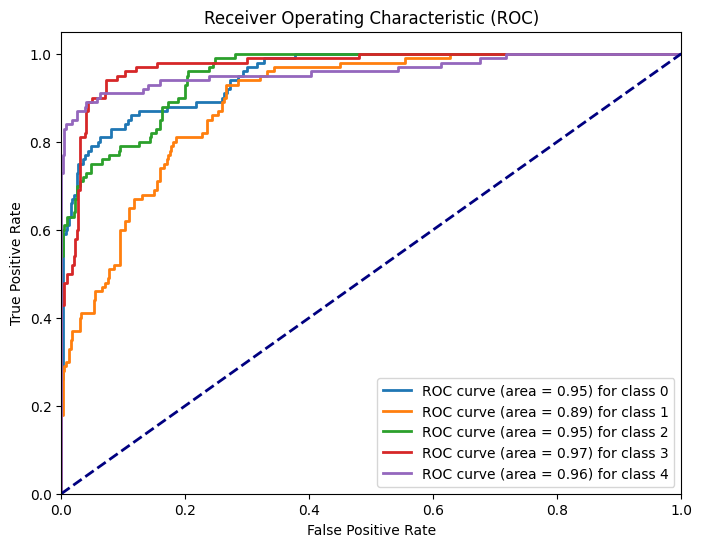

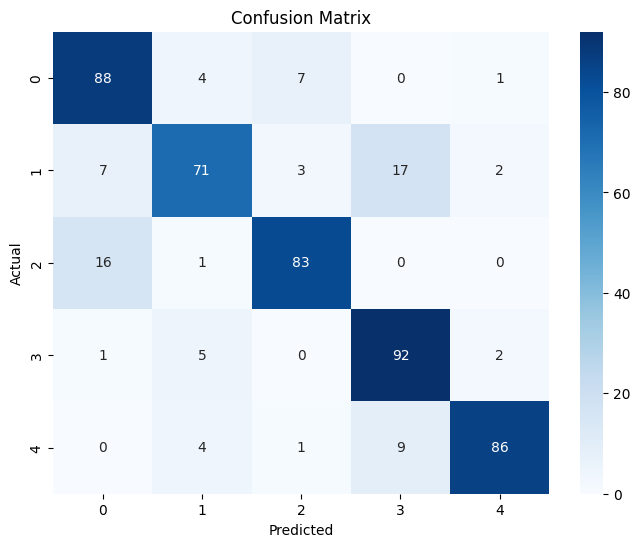

In [ ]:
def evaluate_model_roc_confusion(model, data_loader):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            all_labels.extend(labels.numpy())
            all_scores.extend(outputs.numpy())

    n_classes = len(np.unique(all_labels))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        true_labels = np.array(all_labels) == i
        scores = [score[i] for score in all_scores]
        fpr[i], tpr[i], _ = roc_curve(true_labels, scores)
        roc_auc[i] = roc_auc_score(true_labels, scores)

    # Confusion matrix
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_scores).argmax(axis=1)
    cm = confusion_matrix(all_labels, all_predictions)

    return fpr, tpr, roc_auc, cm

fpr, tpr, roc_auc, cm = evaluate_model_roc_confusion(model, test_loader)

# Plot ROC curves para cada clase
plt.figure(figsize=(8, 6))
n_classes = len(roc_auc)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

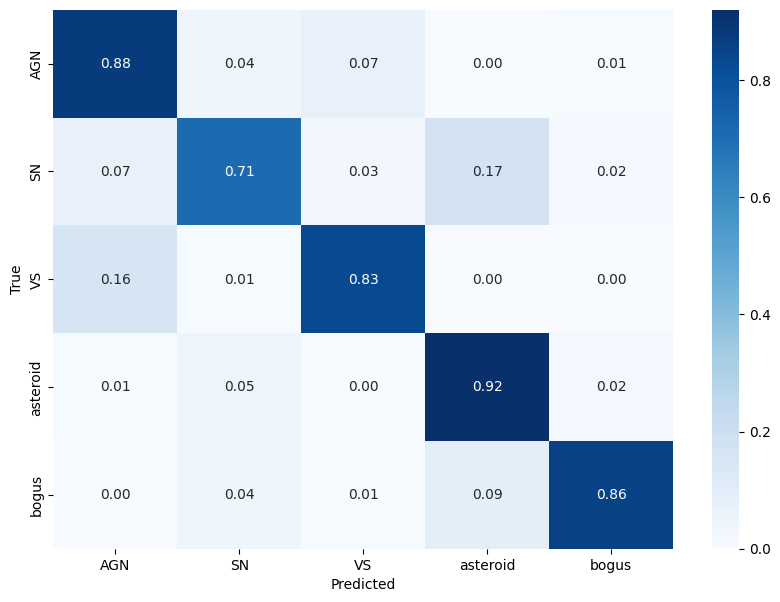

In [ ]:
# Normalizar la matriz de confusión
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = ['AGN', 'SN', 'VS', 'asteroid', 'bogus']

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
def evaluate_model_metrics(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    # Convertir las listas a arrays numpy
    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)

    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision por clase: {precision_per_class}")
    print(f"Recall por clase: {recall_per_class}")
    print(f"F1 Score por clase: {f1_per_class}")
    print(f"Matriz de Confusión:\n{conf_matrix}")

    # Retornar las métricas
    return accuracy, precision_per_class, recall_per_class, f1_per_class, conf_matrix

# Llamar a la función para obtener las métricas
accuracy, precision, recall, f1, conf_matrix = evaluate_model_metrics(model, test_loader)

Accuracy: 0.84
Precision por clase: [0.78571429 0.83529412 0.88297872 0.77966102 0.94505495]
Recall por clase: [0.88 0.71 0.83 0.92 0.86]
F1 Score por clase: [0.83018868 0.76756757 0.8556701  0.8440367  0.90052356]
Matriz de Confusión:
[[88  4  7  0  1]
 [ 7 71  3 17  2]
 [16  1 83  0  0]
 [ 1  5  0 92  2]
 [ 0  4  1  9 86]]
